In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import sys
sys.path.insert(0, "..")
from classes.stat_phys.potentials1 import H_pot_direct_integration as H_pot_int
from classes.stat_phys.potentials1 import H_plain_MonteCarlo as H_pot_mont
#from classes import P_dist_handler, H_pot
plt.rc('animation', html='jshtml')

In [2]:
def p_fun(x,T,k,x_0):
    t1 = np.sqrt(k/(2.0*np.pi*T))
    t2 = np.exp(-1.0/2.0*k*(x-x_0)**2/T)
    return t1*t2

def v_fun(x, k, x_0):
    return 1.0/2.0*k*(x-x_0)**2


ks = [1.0, 1.0, 10.0]
x0s = [0.0,1.0, 0.0]
T = 0.5
Hs_int = []
for k, x0 in zip(ks, x0s):
    v_fun_args = {"k":k, "x_0":x0}
    p_fun_args = {"T":T,"k":k, "x_0":x0}
    h = H_pot_int(T=T, v_func=v_fun, v_func_args=v_fun_args, p_func=p_fun, p_func_args=p_fun_args)
    Hs_int.append(h)

## a) 
Plot the potential of the harmonic oscillator with some different values for the force constant, $k$. Plot the probability distribution. Evaulate the thermally averaged potential energy by direct integration in a finite range from some $x_{min}$ to some $x_{max}$. Neglect for now that this leads to a small error.

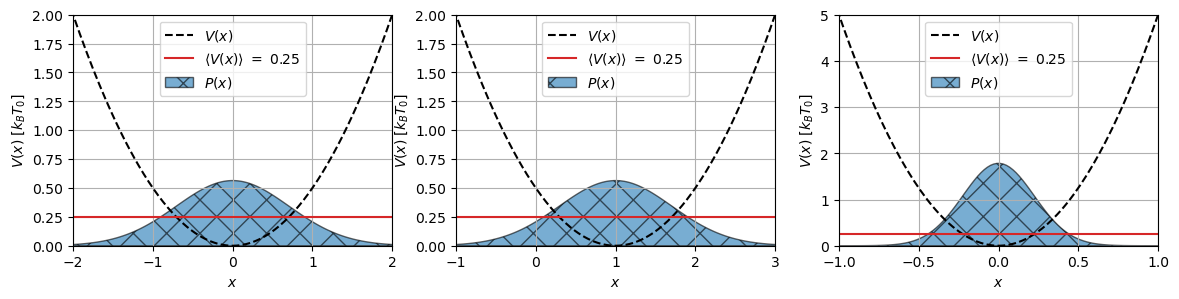

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(14,3))
x_lims = [[-2,2],[-1,3],[-1,1]]
y_lims = [[0,2], [0,2], [0,5]]
xs = np.linspace(-2.0, 2.0, 1000)
#Y = lambda x, T, k, x_0, x_min, x_max: np.sqrt(k/(2.0*np.pi))*np.exp(-k/2.0*(x-x_0)**2)/special.erf(x_max*np.sqrt(k/2.0)) #+ 1.0/(x_max-x_min)
for ax, x_lim, y_lim, pot, k, x0 in zip(axs, x_lims, y_lims, Hs_int, ks, x0s):
    ax.grid()
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$V(x)$ $[k_BT_{0}]$")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    pot.get_v_avg
    pot.plot(ax)
    ax.legend()

#I think the probababilty distributions are wrong, but i cannot recreat bjørks distributions even if i renormalize?

In [4]:
Hs_mont = []
def Y(x, T, k, x_0):
    return np.exp(-1.0/2.0*k*(x-x_0)**2/T)

ks = [1.0, 1.0, 10.0]
x0s = [0.0,1.0, 0.0]
T = 0.5

for k, x0 in zip(ks, x0s):
    v_fun_args = {"k":k, "x_0":x0}
    y_args = {"T":T,"k":k, "x_0":x0}
    h = H_pot_mont(T=T, v_func=v_fun, v_func_args=v_fun_args, Y=Y, Y_args=y_args, N=10000)
    Hs_mont.append(h)

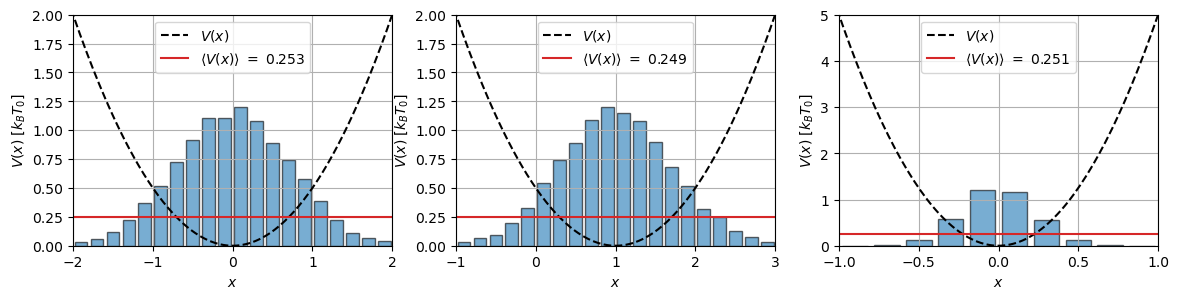

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(14,3))
x_lims = [[-2,2],[-1,3],[-1,1]]
y_lims = [[0,2], [0,2], [0,5]]

for ax, x_lim, y_lim, pot, k, x0 in zip(axs, x_lims, y_lims, Hs_mont, ks, x0s):
    ax.grid()
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$V(x)$ $[k_BT_0]$")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    pot.plot(ax)
    ax.legend()

In [7]:
Ts = np.linspace(0.01, 2.0, 2000)
cvs_energy = []
cvs_fluct = []
for T in Ts:
    Hs_int[0].set_temperature(T)
    cv = Hs_int[0].get_cv("finite_difference", T_step=1e-3)
    cvs_energy.append(cv)
    cv = Hs_int[0].get_cv("analytical")
    cvs_fluct.append(cv)

Text(0, 0.5, '$C_v$ $\\left[k_B\\right]$')

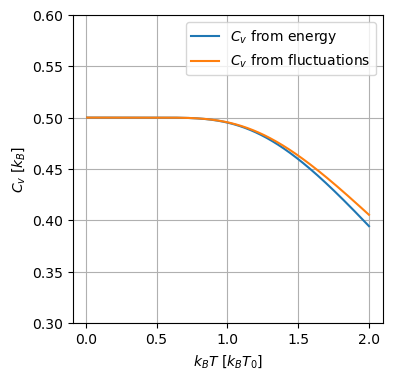

In [21]:
fig, ax = plt.subplots(figsize=(4,4))
#ax.set_ylim([0.0,0.7])
ax.set_ylim([0.30, 0.6])
ax.plot(Ts, np.array(cvs_energy), label=r"$C_v$ from energy")
ax.plot(Ts, np.array(cvs_fluct), label=r"$C_v$ from fluctuations")
ax.grid()
ax.legend()
ax.set_xlabel(r"$k_BT$ $\left[k_BT_0\right]$")
ax.set_ylabel(r"$C_v$ $\left[k_B\right]$")
#ax.set_xlim([200,300])